In [8]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Подключим Keras и все необходимые нам модули

In [9]:
import keras
from keras import applications
from keras.applications import imagenet_utils
from keras import backend as K
import numpy as np
import tensorflow as tf

In [10]:
from keras.utils.vis_utils import model_to_dot

In [11]:
from skimage.transform import resize

In [12]:
from imageio import imread, imwrite

In [13]:
sess = K.get_session()
sess.as_default()

In [14]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

В модуле applications вы сможете найти большое количество предтренированных моделей. Загрузим уже знакомый нам VGG16, обученный на Imagenet

In [15]:
# build the VGG16 network
K.clear_session()
model = applications.VGG16(include_top=True,
                           weights='imagenet',
                           input_shape=(224, 224, 3))

В Keras существуют удобные средства для визуализации моделей. 

In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Так же мы можем вывести на экран граф модели:

In [17]:
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

Загрузим произвольную фотографию. Можно из http://image-net.org/, а можно и просто произвольную.

In [31]:
image = imread('https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/08/Coffee-Mug.jpg')

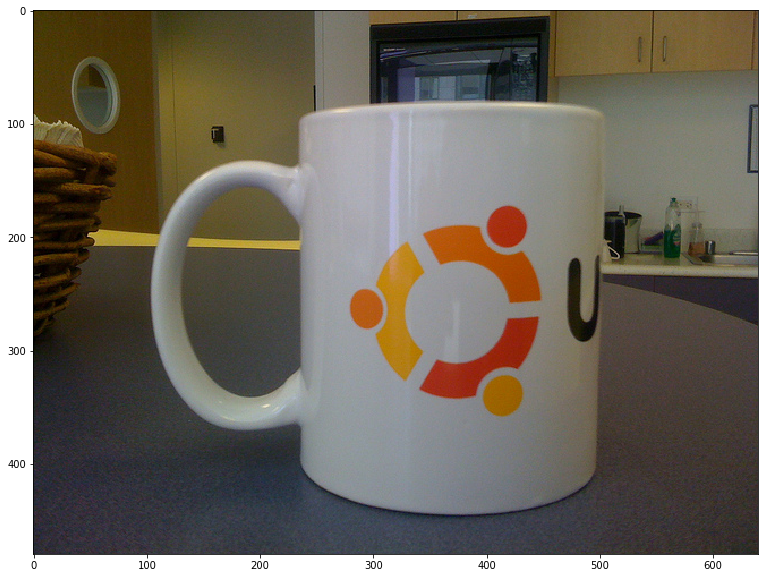

In [32]:
plt.imshow(image)

Обратите внимание, что изображения должнв иметь разрешение 224х224

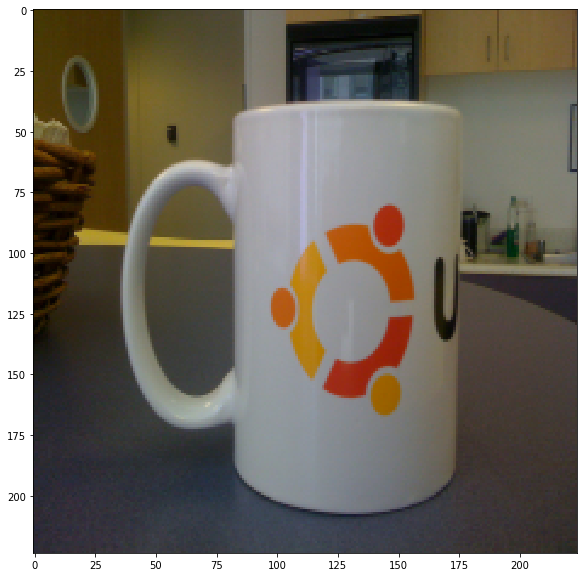

In [40]:
resized_image = resize(image, (224, 224)).astype(np.float32)
plt.imshow(resized_image)


Проверим может ли модель определить, к какому классу относится объект на изображении

In [43]:
# mean_pixel2 = [116.779, 123.68, 103.939]
# mean_pixel = [103.939, 116.779, 123.68]
# img = resized_image.astype(np.float32, copy=False)
# for c in range(3):
#     img[:, :, c] = img[:, :, c] - mean_pixel[c]
# img = img.transpose((1,0,2))
# img = np.expand_dims(img, axis=0)
# #img /= 255.

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

img = resized_image
img *= 255.
img.add(vgg_mean)

AttributeError: 'numpy.ndarray' object has no attribute 'add'

In [39]:
# #im = resized_image.transpose((2,0,1))
# img = resized_image
# #im /= 255.
img = np.expand_dims(img, axis=0)
#from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
#image = preprocess_input(resized_image)
y = model.predict(img)

In [36]:
np.argmax(y)

504

В Keras есть специальная функция, которая достаёт лейблы классов из Imagenet

In [37]:
imagenet_utils.decode_predictions(y)

[[('n03063599', 'coffee_mug', 0.7554778),
  ('n07930864', 'cup', 0.07675178),
  ('n03063689', 'coffeepot', 0.047262773),
  ('n03950228', 'pitcher', 0.042266235),
  ('n04560804', 'water_jug', 0.035210077)]]

Теперь определим функцию, считающую градиент от выходов модели 

In [ ]:
# Получаем тензор, отвечающий за вход модели
input_img = model.input

# Получаем тензор, отвечающий за выход
output = model.output
# s_output = K.softmax(model.output)

# Вызываем метод бэкенда, рассчитывающий градиент
grads = K.gradients(output, input_img)[0]

# Оборачиваем всё это в специальную абстракцию,
# которая скрывает вызов сессии TF
get_gradient = K.function([input_img], [grads])

Теперь мы можем рассчитать градиент

In [ ]:
grad_val = get_gradient([np.expand_dims(resized_image, 0)])[0]

Как видим, shape градиента совпадает с shape изображения

In [ ]:
grad_val.shape

In [ ]:
grad_val = np.squeeze(grad_val)

Для того, чтобы "посветить" значимые области найдём максимум поканально

In [ ]:
mask = np.max(np.abs(grad_val), axis=-1)

In [ ]:
plt.imshow(mask, cmap='gray')

In [ ]:
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(mask, cmap='gray')
a.set_title('Saliency Map')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(resized_image)
a.set_title('Image')
plt.show()